In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
plt.rcParams['figure.figsize']  = (16, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

plt.ion()
plt.style.use('seaborn-colorblind')

<ipython-input-3-9e0153af9344>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


In [ ]:
import requests
import io

response = requests.get('http://dcc.ufmg.br/~flaviovdf/MICRODADOS_ENEM_2020_FILTRADOS.csv', verify=False)

# Check if the request was successful (HTTP status code 200)
if response.status_code == 200:
    # Read the CSV data into a DataFrame
    csv_data = response.text
    df = pd.read_csv(io.StringIO(csv_data))

    # Now, 'df' contains the CSV data as a DataFrame
    # You can work with the data using pandas functions
else:
    print(f"HTTP request failed with status code {response.status_code}")

enem = df

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dcc.ufmg.br'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'homepages.dcc.ufmg.br'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [ ]:
enem.head()

,NU_INSCRICAO,SG_UF_ESC,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,TP_ANO_CONCLUIU,NU_NOTA_REDACAO,NU_NOTA_CN,TP_FAIXA_ETARIA,Q005,Q006,NU_NOTA_MT,NU_NOTA_CH,NU_NOTA_LC,TP_ESCOLA
0,200006271946,NaN,0,0,0,0,11,NaN,NaN,11,NaN,NaN,NaN,NaN,NaN,1
1,200001195856,NaN,1,1,1,1,11,580.0,604.1,11,NaN,NaN,711.3,661.7,595.3,1
2,200001943954,BA,0,0,0,0,0,NaN,NaN,4,3.0,B,NaN,NaN,NaN,2
3,200001908998,SP,1,1,1,1,0,760.0,620.8,2,NaN,NaN,759.4,675.0,624.2,2
4,200001634757,NaN,0,0,0,0,1,NaN,NaN,4,3.0,B,NaN,NaN,NaN,1


In [ ]:
enem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5783109 entries, 0 to 5783108
Data columns (total 16 columns):
 #   Column           Dtype  
---  ------           -----  
 0   NU_INSCRICAO     int64  
 1   SG_UF_ESC        object 
 2   TP_PRESENCA_CN   int64  
 3   TP_PRESENCA_CH   int64  
 4   TP_PRESENCA_LC   int64  
 5   TP_PRESENCA_MT   int64  
 6   TP_ANO_CONCLUIU  int64  
 7   NU_NOTA_REDACAO  float64
 8   NU_NOTA_CN       float64
 9   TP_FAIXA_ETARIA  int64  
 10  Q005             float64
 11  Q006             object 
 12  NU_NOTA_MT       float64
 13  NU_NOTA_CH       float64
 14  NU_NOTA_LC       float64
 15  TP_ESCOLA        int64  
dtypes: float64(6), int64(8), object(2)
memory usage: 705.9+ MB


# Exercício 1
Quais os 5 estados brasileiros com maior taxa de ausência (geral) no ENEM 2020?

In [ ]:
df_estados_filtrados = enem[["SG_UF_ESC", "TP_PRESENCA_CN", "TP_PRESENCA_CH", "TP_PRESENCA_LC", "TP_PRESENCA_MT"]].dropna()

condicao_alunos_ausentes = (df_estados_filtrados["TP_PRESENCA_CN"] == 0) | (df_estados_filtrados["TP_PRESENCA_CN"] == 0) | (df_estados_filtrados["TP_PRESENCA_CN"] == 0) | (df_estados_filtrados["TP_PRESENCA_CN"] == 0)

df_apenas_ausencias = df_estados_filtrados[condicao_alunos_ausentes]
df_contagem_ausencias = (
                          df_apenas_ausencias.
                            groupby("SG_UF_ESC").
                            count().
                            rename(columns={"TP_PRESENCA_CN": "Quantidade_Ausencias"}).
                            reset_index().
                            sort_values(by="Quantidade_Ausencias", ascending = False)
                        )

df_contagem_ausencias[["SG_UF_ESC", "Quantidade_Ausencias"]].head(5)

,SG_UF_ESC,Quantidade_Ausencias
25,SP,68602
5,CE,52536
10,MG,24591
18,RJ,21995
15,PE,19917


# Exercício 2
Como a probabilidade de um(a) candidato(a) obter nota superior a 600 na redação varia com o tempo desde que ele(a) concluiu o segundo grau? Esta tendência é a mesma observada em Ciências da natureza?

**Ovservação:** O valor da coluna TP_ANO_CONCLUIU já indica o tempo desde a conclusão até prova. Entretanto, o valor 0 não necessariamente indica que o estudante concluiu em 2020! Elimine este valor para análises mais precisas.

In [ ]:
def CalcularTendencia(df, nota_referencia):
  # Limpando os dados
  df_filtrado = df[[nota_referencia, "TP_ANO_CONCLUIU"]]
  df_filtrado = df_filtrado.drop(df_filtrado[df_filtrado["TP_ANO_CONCLUIU"] == 0].index)
  df_filtrado = df_filtrado.dropna()

  # Contando quantidade alunos com mais de 600
  df_probabilidade = (
                      df_filtrado[df_filtrado[nota_referencia] > 600].
                        groupby("TP_ANO_CONCLUIU").
                        count().
                        rename(columns={nota_referencia: "Contagem_Alunos_600_mais"}).
                        reset_index()
                      )

  # Contando total de alunos
  df_probabilidade["Contagem_Total_Alunos"] = (
                                                df_filtrado.
                                                groupby("TP_ANO_CONCLUIU").
                                                count().
                                                rename(columns={nota_referencia: "Contagem_Alunos"}).
                                                reset_index()
                                              )["Contagem_Alunos"]

  # Calculando probabilidade de tirar mais que 600
  df_probabilidade["Probabilidade"] = df_probabilidade["Contagem_Alunos_600_mais"] / df_probabilidade["Contagem_Total_Alunos"]
  return df_probabilidade

In [ ]:
df_probabilidade = CalcularTendencia(enem, "NU_NOTA_REDACAO")
df_probabilidade

Text(0, 0.5, 'Probabilidade tirar mais que 600')

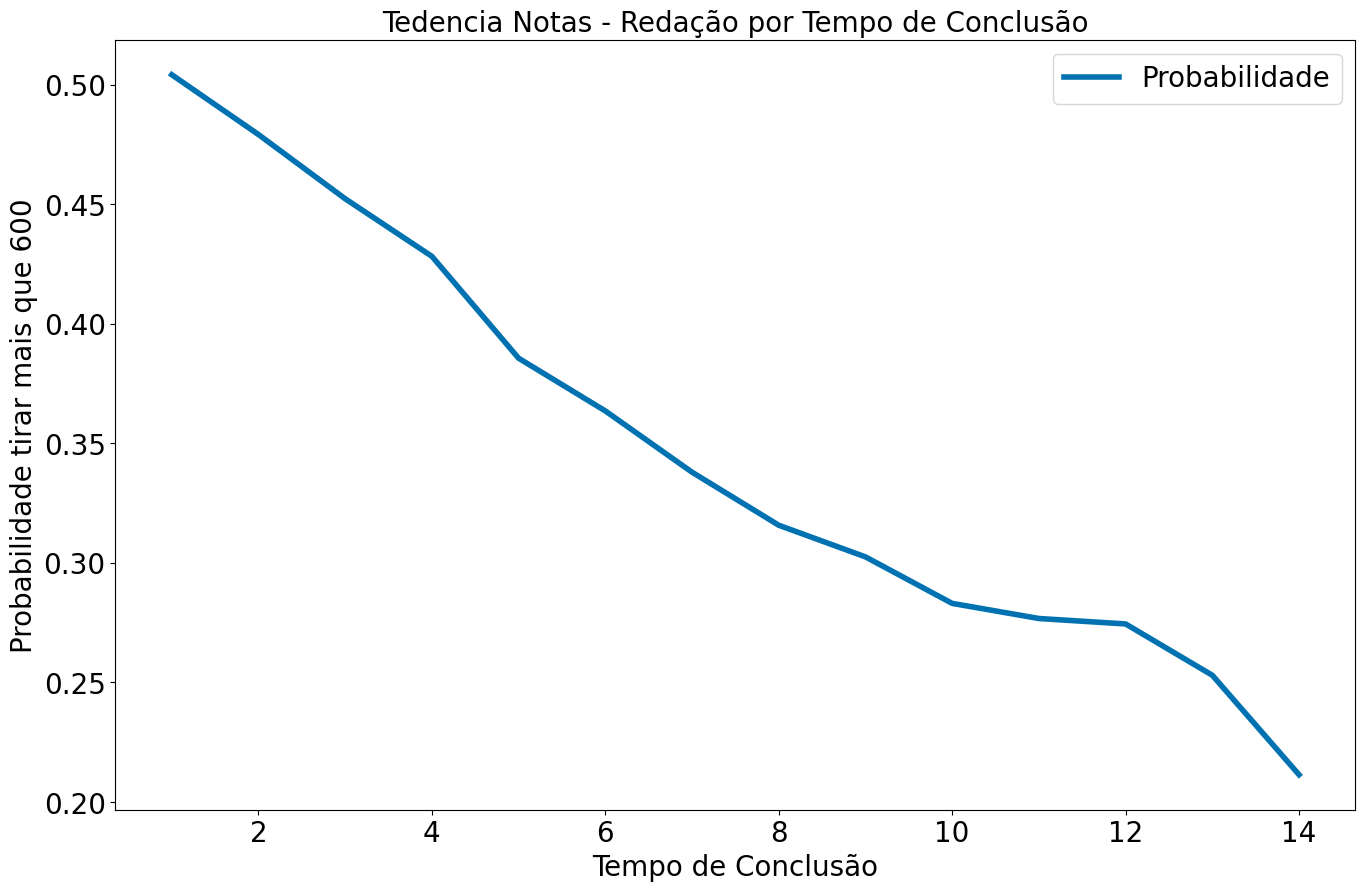

In [ ]:
df_probabilidade.plot.line(x="TP_ANO_CONCLUIU", y="Probabilidade")

plt.title("Tedencia Notas - Redação por Tempo de Conclusão")
plt.xlabel('Tempo de Conclusão')
plt.ylabel('Probabilidade tirar mais que 600')

In [ ]:
df_probabilidade = CalcularTendencia(enem, "NU_NOTA_CN")
df_probabilidade

,TP_ANO_CONCLUIU,Contagem_Alunos_600_mais,Contagem_Total_Alunos,Probabilidade
0,1,39838,335331,0.118802
1,2,25462,199284,0.127767
2,3,18930,138834,0.136350
3,4,13261,96282,0.137731
4,5,9398,74878,0.125511
5,6,7034,59020,0.119180
6,7,5409,47257,0.114459
7,8,4314,39345,0.109645
8,9,3534,31564,0.111963
9,10,3017,28639,0.105346


Text(0, 0.5, 'Probabilidade tirar mais que 600')

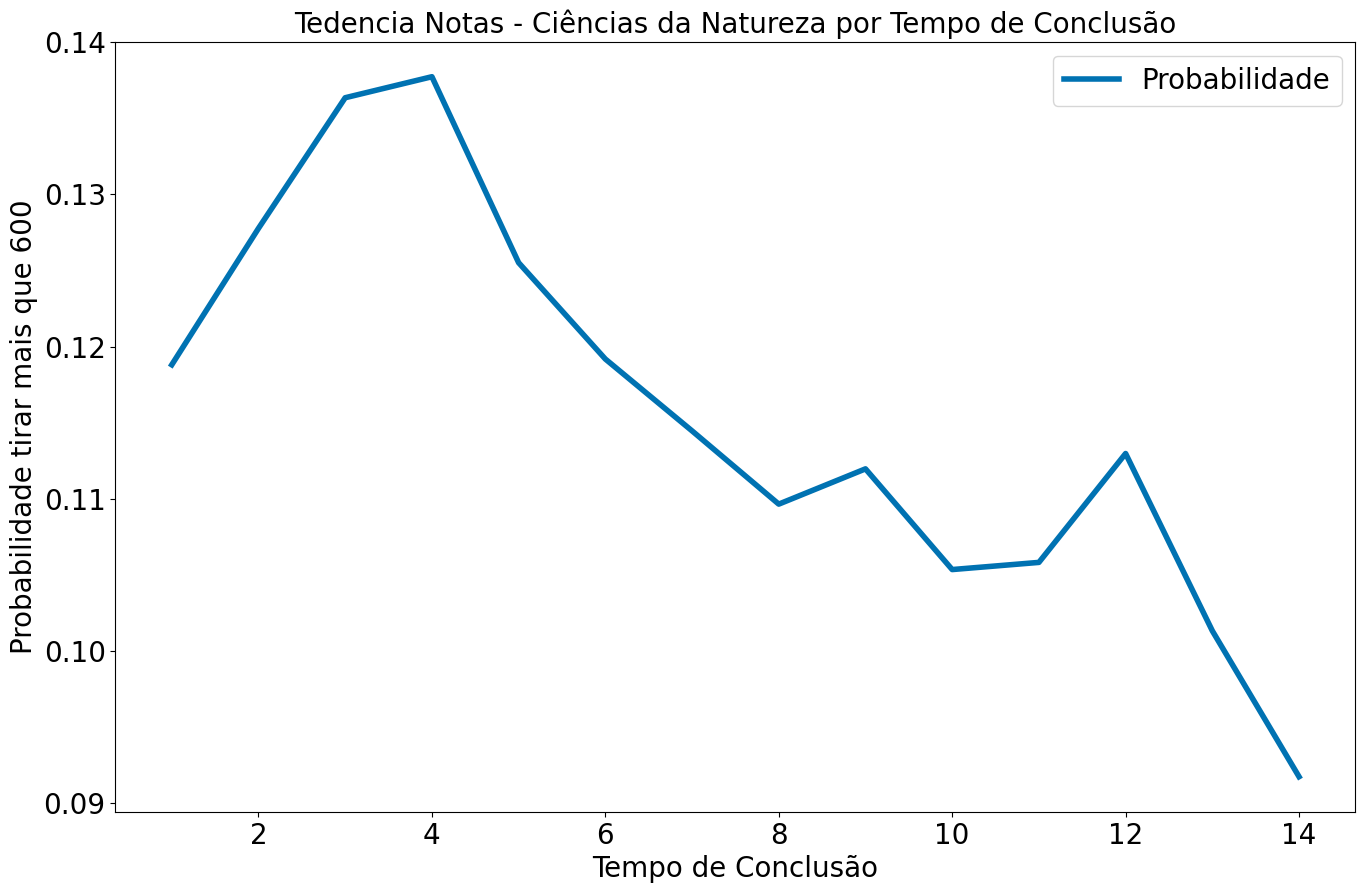

In [ ]:
df_probabilidade.plot.line(x="TP_ANO_CONCLUIU", y="Probabilidade")

plt.title("Tedencia Notas - Ciências da Natureza por Tempo de Conclusão")
plt.xlabel('Tempo de Conclusão')
plt.ylabel('Probabilidade tirar mais que 600')

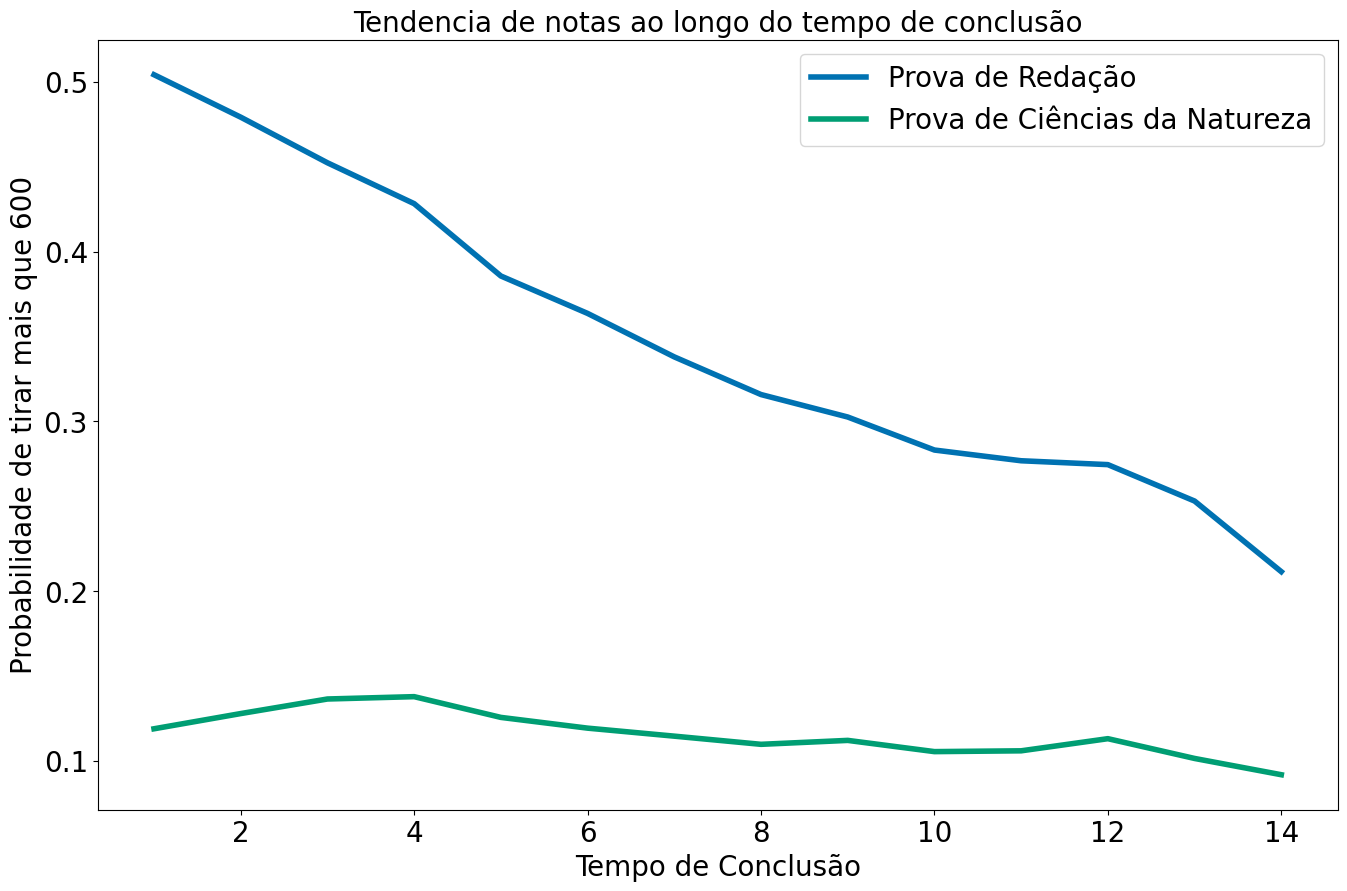

In [ ]:
df_probabilidade_re = CalcularTendencia(enem, "NU_NOTA_REDACAO")
df_probabilidade_cn = CalcularTendencia(enem, "NU_NOTA_CN")

plt.plot(df_probabilidade_re["TP_ANO_CONCLUIU"], df_probabilidade_re["Probabilidade"], label="Prova de Redação")
plt.plot(df_probabilidade_cn["TP_ANO_CONCLUIU"], df_probabilidade_cn["Probabilidade"], label="Prova de Ciências da Natureza")

plt.xlabel("Tempo de Conclusão")
plt.ylabel("Probabilidade de tirar mais que 600")
plt.legend()
plt.title('Tendencia de notas ao longo do tempo de conclusão')
plt.show()

É possível notar que ambas tem uma tendência a decair a medida que o Tempo de Conclusão aumenta.

No entanto, é possível notar que a nota de Redação decai em uma velocidade muito maior que a de Ciências da Natureza, muito provavelmente devido ao estilo específico exigido de escrita nas provas de redação do Enem. Como ele não é incentivado ao longo do tempo, essa forma de escrita vai se perdendo a medida que não é praticada.

# Exercício 3

Como fatores como renda (Q006), número de pessoas que moram na mesma residência que o candidato (Q005), e a faixa etária (TP_FAIXA_ETARIA) do participante influenciam em sua nota em Matemática?

**Sugestões:** Para análises mais precisas, elimine as notas 0 e os candidatos que faltaram nas provas analisadas (ex:TP_PRESENCA_MT=0). Como as notas são uma escala contínua, você pode optar, se preferir, por torná-la discreta, criando classes que englobem faixas de notas (ex: 200<NU_NOTA_MT<400).

In [ ]:
df_filtrado = enem[["NU_NOTA_MT", "TP_PRESENCA_MT", "Q005", "Q006", "TP_FAIXA_ETARIA"]]
df_filtrado = df_filtrado.rename(columns={"Q005": "Quantidade_Pessoas_na_Residencia", "Q006": "Renda"})

# Removendo alunos ausentes
df_filtrado = df_filtrado.dropna()
df_filtrado = df_filtrado.drop((df_filtrado[df_filtrado["TP_PRESENCA_MT"] == 0]).index)

# Removendo alunos com nota zero (redundancia)
df_filtrado = df_filtrado.drop((df_filtrado[df_filtrado["NU_NOTA_MT"] == 0]).index)

# Atribui nota a faixas
faixas = [df_filtrado["NU_NOTA_MT"].between(0, 200), df_filtrado["NU_NOTA_MT"].between(200, 400), df_filtrado["NU_NOTA_MT"].between(400, 600), df_filtrado["NU_NOTA_MT"].between(600, 800), df_filtrado["NU_NOTA_MT"].between(800, 1000)]
categorias = ["Menor que 200", "Entre 200 e 400", "Entre 400 e 600", "Entre 600 e 800", "Maior que 800"]

df_filtrado["Faixa_Nota"] = np.select(faixas, categorias, 0)

Relação entre Nota e Renda

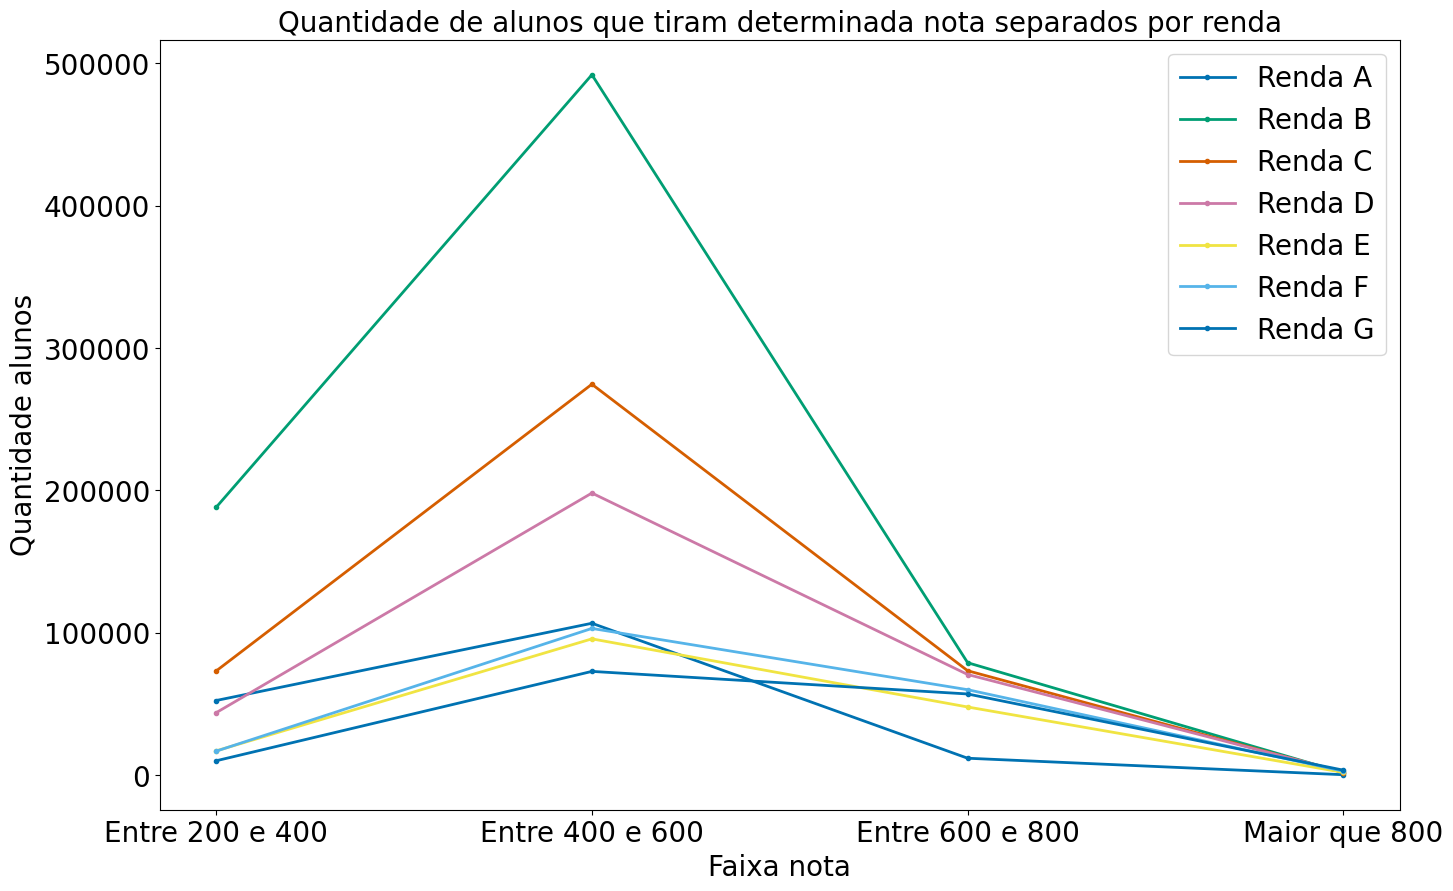

In [ ]:
for char in "ABCDEFG":
  df_renda_atual = df_filtrado.loc[df_filtrado["Renda"] == char, ["Faixa_Nota", "Renda"]]
  df_renda_atual = df_renda_atual.groupby("Faixa_Nota").count().reset_index()

  faixa_renda = "Renda " + char
  plt.plot(df_renda_atual["Faixa_Nota"], df_renda_atual["Renda"], label=faixa_renda, linewidth=2, marker=".")

plt.xlabel("Faixa nota")
plt.ylabel("Quantidade alunos")
plt.legend()
plt.title("Quantidade de alunos que tiram determinada nota separados por renda")

plt.show()

Relação entre Nota e Quantidade de Pessoas na Mesma Residência

[]

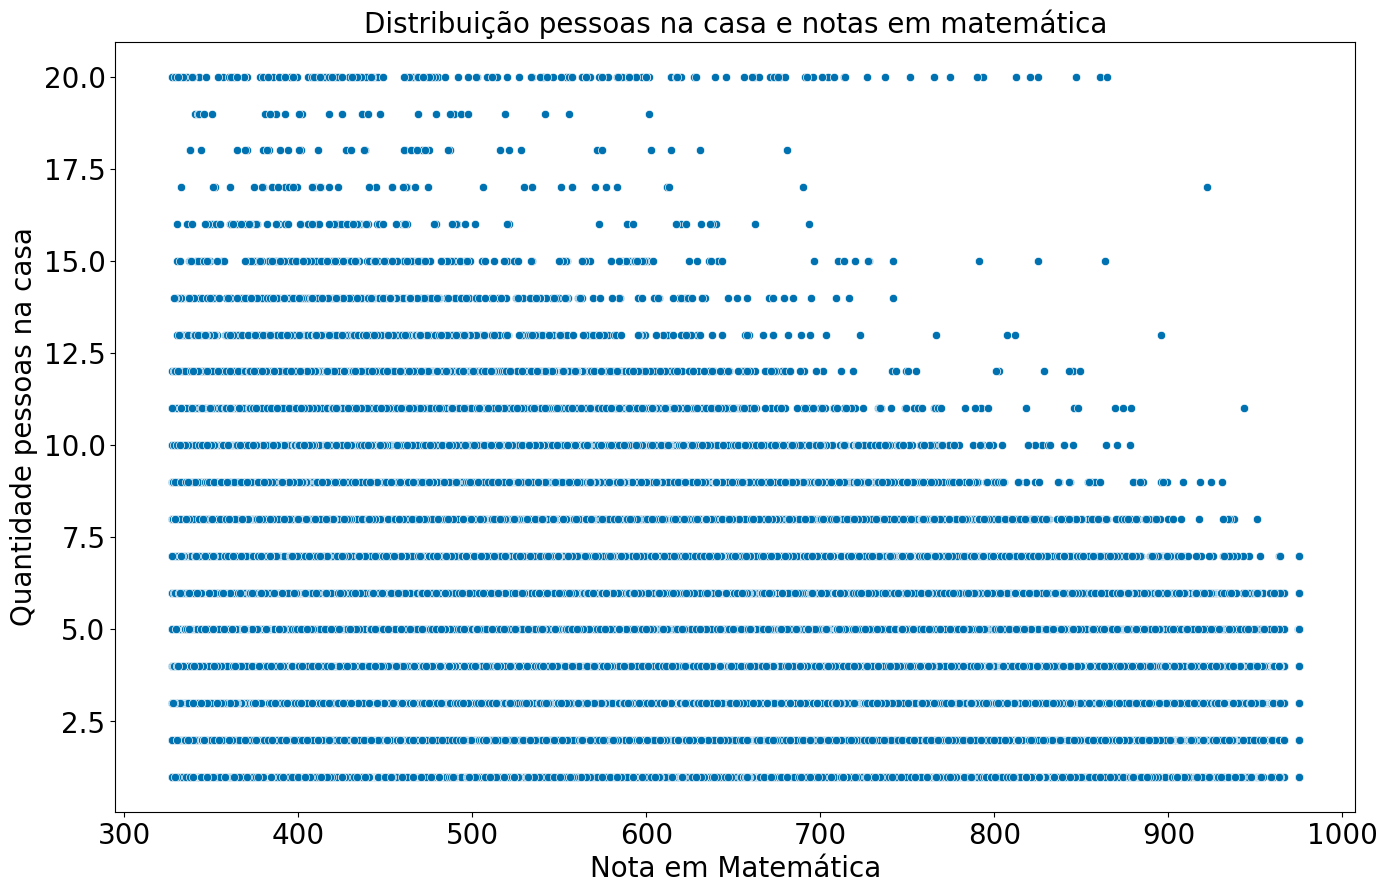

In [ ]:
df_scatter = df_filtrado[["Quantidade_Pessoas_na_Residencia", "NU_NOTA_MT"]]
df_scatter = df_scatter.astype({'Quantidade_Pessoas_na_Residencia': int})

axes = sns.scatterplot(data=df_scatter, x="NU_NOTA_MT", y="Quantidade_Pessoas_na_Residencia")

axes.set_title("Distribuição pessoas na casa e notas em matemática")
axes.set_ylabel("Quantidade pessoas na casa")
axes.set_xlabel("Nota em Matemática")
axes.plot()

In [ ]:
df_pessoas_residencia = df_filtrado[["Faixa_Nota", "Quantidade_Pessoas_na_Residencia"]]

maior_quantidade_pessoas_residentes = df_pessoas_residencia["Quantidade_Pessoas_na_Residencia"].max()

faixas_pessoas_residentes = [
                              df_pessoas_residencia["Quantidade_Pessoas_na_Residencia"].between(0, 4),
                              df_pessoas_residencia["Quantidade_Pessoas_na_Residencia"].between(4, 8),
                              df_pessoas_residencia["Quantidade_Pessoas_na_Residencia"].between(8, maior_quantidade_pessoas_residentes + 1)
                            ]

categorias_pessoas_residentes = [
                                  "1 a 3 pessoas",
                                  "4 a 7 pessoas",
                                  "8 ou mais"
                                ]

df_pessoas_residencia["Faixa_Pessoas"] = np.select(faixas_pessoas_residentes, categorias_pessoas_residentes, 0)

for categoria in categorias_pessoas_residentes:
  df_atual = df_pessoas_residencia.loc[df_pessoas_residencia["Faixa_Pessoas"] == categoria]
  df_atual = df_atual.groupby("Faixa_Nota").count().reset_index()

  plt.plot(df_atual["Faixa_Nota"], df_atual["Quantidade_Pessoas_na_Residencia"], label=categoria, linewidth=2, marker=".")

plt.xlabel("Faixa nota")
plt.ylabel("Quantidade alunos")
plt.legend()
plt.title("Quantidade de alunos que tiram determinada nota separados por quantidade de pessoas na residência")

plt.show()

NameError: ignored

Relação entre Nota e Faixa Etária

[]

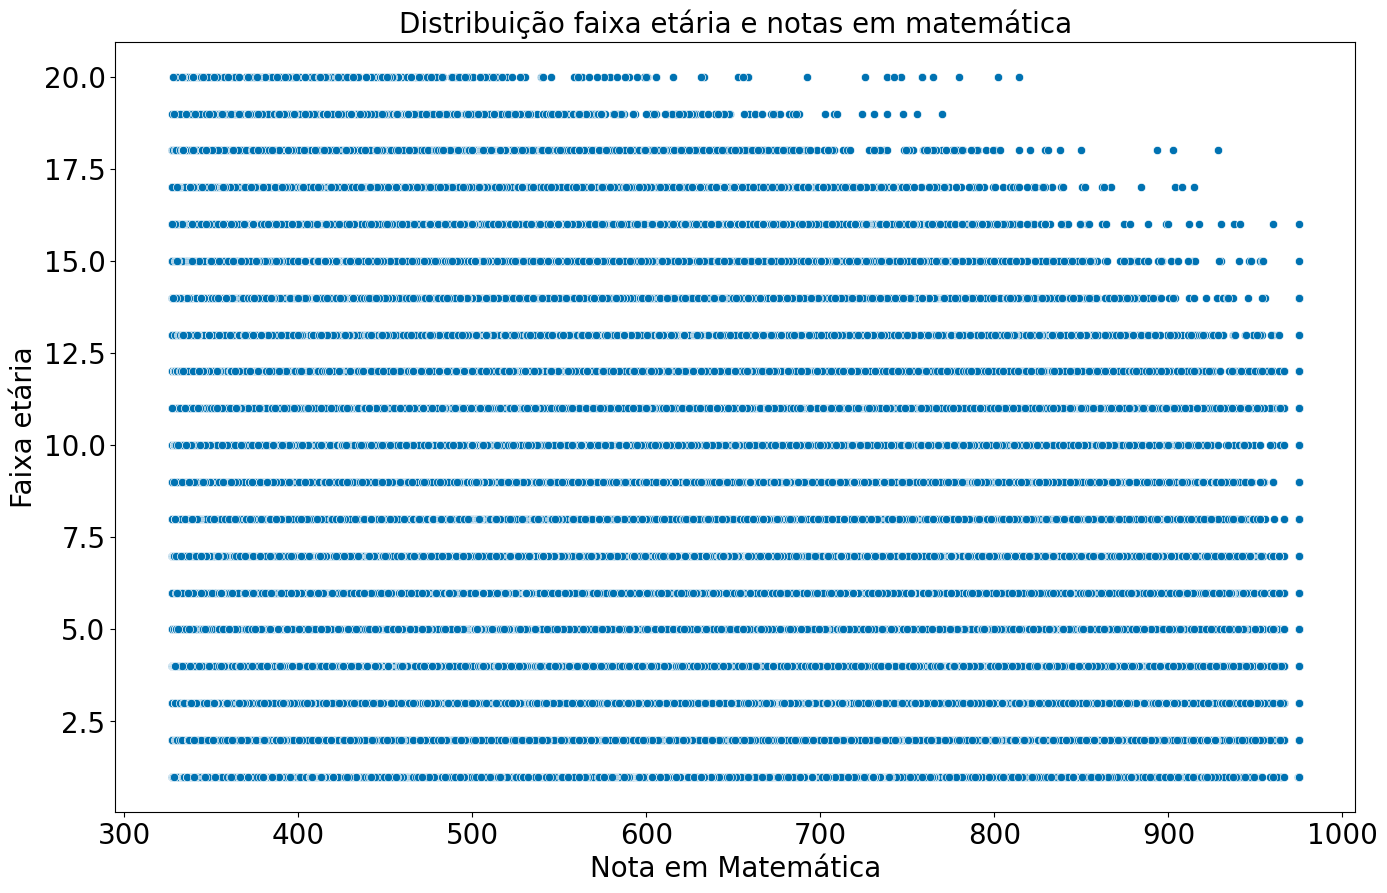

In [ ]:
df_scatter = df_filtrado[["TP_FAIXA_ETARIA", "NU_NOTA_MT"]]
df_scatter = df_scatter.astype({'TP_FAIXA_ETARIA': int})

axes = sns.scatterplot(data=df_scatter, x="NU_NOTA_MT", y="TP_FAIXA_ETARIA")

axes.set_title("Distribuição faixa etária e notas em matemática")
axes.set_ylabel("Faixa etária")
axes.set_xlabel("Nota em Matemática")
axes.plot()

<ipython-input-18-06f35308a445>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_faixa_etaria["Faixa_Etarias"] = np.select(faixas_etarias, categorias_etarias, 0)


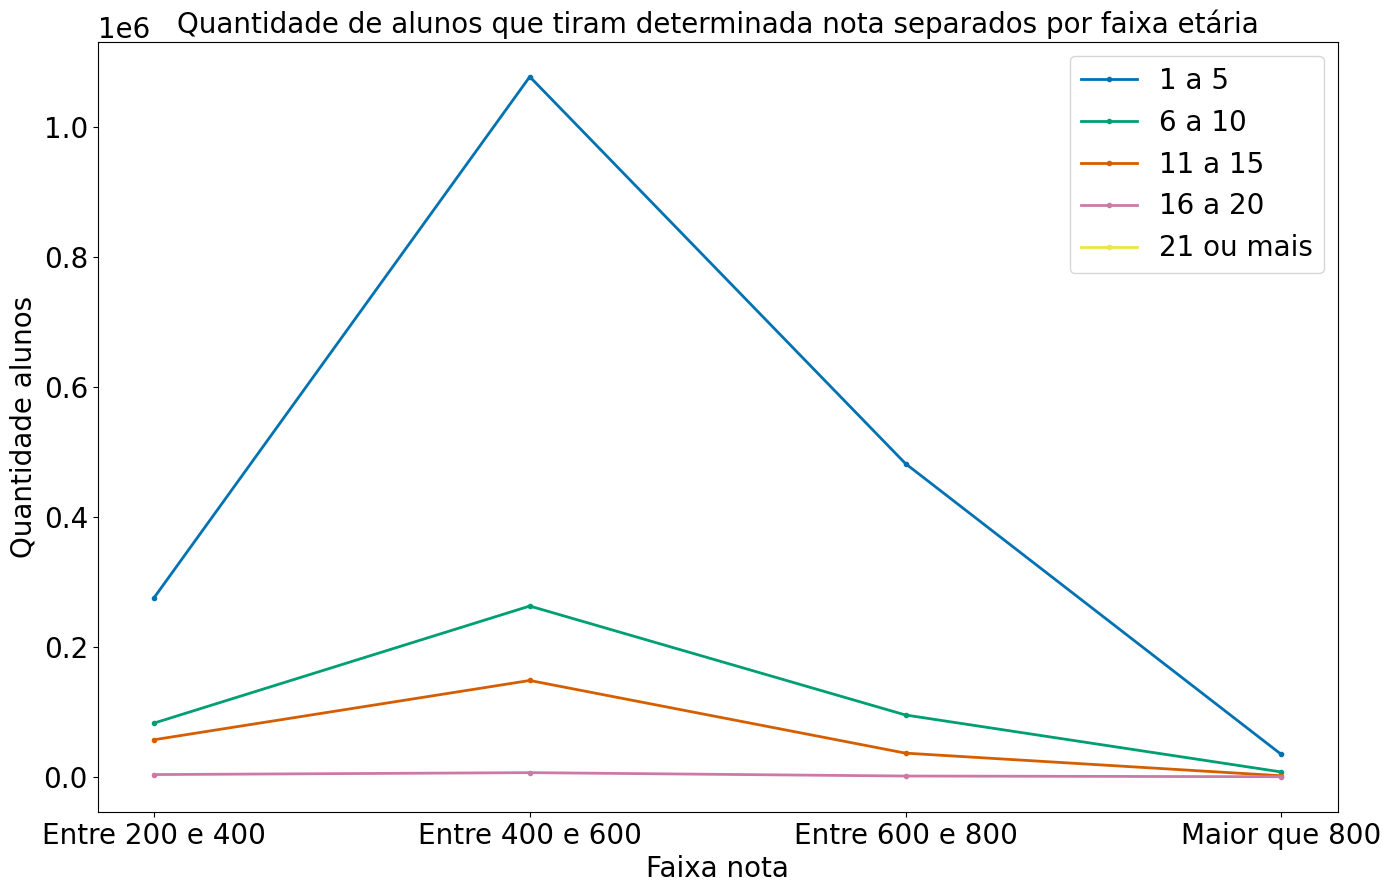

In [ ]:
df_faixa_etaria = df_filtrado[["Faixa_Nota", "TP_FAIXA_ETARIA"]]

maior_faixa_etaria = df_faixa_etaria["TP_FAIXA_ETARIA"].max()

faixas_etarias = [
                    df_faixa_etaria["TP_FAIXA_ETARIA"].between(0, 6),
                    df_faixa_etaria["TP_FAIXA_ETARIA"].between(6, 11),
                    df_faixa_etaria["TP_FAIXA_ETARIA"].between(11, 16),
                    df_faixa_etaria["TP_FAIXA_ETARIA"].between(16, 21),
                    df_faixa_etaria["TP_FAIXA_ETARIA"].between(21, maior_faixa_etaria + 1)
                 ]

categorias_etarias = [
                      "1 a 5",
                      "6 a 10",
                      "11 a 15",
                      "16 a 20",
                      "21 ou mais"
                     ]

df_faixa_etaria["Faixa_Etarias"] = np.select(faixas_etarias, categorias_etarias, 0)

for categoria in categorias_etarias:
  df_atual = df_faixa_etaria.loc[df_faixa_etaria["Faixa_Etarias"] == categoria]
  df_atual = df_atual.groupby("Faixa_Nota").count().reset_index()

  plt.plot(df_atual["Faixa_Nota"], df_atual["Faixa_Etarias"], label=categoria, linewidth=2, marker=".")

plt.xlabel("Faixa nota")
plt.ylabel("Quantidade alunos")
plt.legend()
plt.title("Quantidade de alunos que tiram determinada nota separados por faixa etária")

plt.show()